In [2]:
## install packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [46]:
## import dataset
train = pd.read_csv('/Users/mac/Documents/GitHub/NatHacks2022/model/dataset/dreaddit-train.csv',encoding = "ISO-8859-1")
test = pd.read_csv('/Users/mac/Documents/GitHub/NatHacks2022/model/dataset/dreaddit-test.csv',encoding = "ISO-8859-1")

In [47]:
domain = {'domesticviolence':'abuse',
          'survivorsofabuse':'abuse',
          'anxiety': 'anxiety',
          'stress': 'anxiety', 
          'almosthomeless': 'financial',
          'assistance': 'financial',
          'food_pantry': 'financial', 
          'homeless': 'financial',
          'ptsd': 'ptsd',
          'relationships': 'social'}

train['domain'] = train['subreddit'].map(domain)
test['domain'] = test['subreddit'].map(domain)

In [51]:
# tokenization: breaks the string into list of words
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [52]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [53]:
from tqdm import tqdm


In [54]:
tqdm.pandas()
train['processed_text'] = train['processed_text'].progress_apply(lambda x: remove_stopwords(x))

100%|███████████████████████████████████████| 2838/2838 [00:55<00:00, 50.69it/s]


In [55]:
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

In [56]:
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

In [57]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/mac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [58]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text


In [59]:
train['processed_text'] = train['processed_text'].apply(lambda x: word_lemmatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lemmatizer(x))

In [60]:
train['processed_text'] = train['processed_text'].apply(lambda x: ' '.join(x))

In [61]:
train['text'].iloc[0]

'He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.'

In [62]:
train['processed_text'].iloc[0]

'said felt way sugget go rest trigger ahead youi hypocondriac like decid look feel doom hope mayb get suck rabbit hole ludicr conspiraci stupid psychic test new age someth could even laugh road end read sen doom indic variou health ailment one prone top doom gloom worri heart happen physic hour'

In [63]:
## find tf-idf of unigram, bigram, and trigram

train_corpus = train['processed_text']

test['processed_text'] = test['processed_text'].apply(lambda x: ' '.join(x))
test_corpus = test['processed_text']

In [64]:
X = train_corpus.append(test_corpus)
X = X.reset_index(drop=True)

/var/folders/h0/cjqhnpy91bx4k51qwqbj9d_m0000gn/T/ipykernel_1443/2365189986.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = train_corpus.append(test_corpus)


In [65]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1)) #unigram, bigram, trigram
X_new = vectorizer.fit_transform(X)

X_train = X_new.toarray()[:len(train)]
X_test = X_new.toarray()[len(train):]

In [66]:
def top_tfidf_features(row, features, top_n):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_features = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_features)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_post(data, features, row_id, top_n):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(data[row_id])
    return top_tfidf_features(row, features, top_n)

In [67]:
features = vectorizer.get_feature_names_out()
top_features_in_post(X_train, features, 0, 10)

,feature,tfidf
0,doom,0.515735
1,hypocondriac,0.197489
2,youi,0.197489
3,conspiraci,0.197489
4,ludicr,0.197489
5,gloom,0.197489
6,sugget,0.197489
7,ailment,0.188049
8,psychic,0.181352
9,rabbit,0.171912


In [68]:
def top_mean_features_by_label(X, y, features, top_n, label_id):
    ids = np.where(y == label_id)
    
    if ids:
        new_data = X[ids]
    else:
        new_data = X


    tfidf_means = np.mean(new_data, axis=0)
    feature_df = top_tfidf_features(tfidf_means, features, top_n)
    feature_df['label'] = label_id

    return feature_df 

In [69]:
non_stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 0)
stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 1)

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of ticklabels (200).

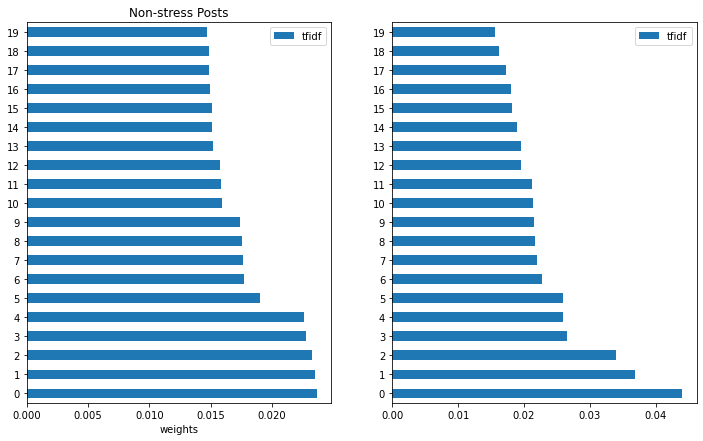

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
non_stress_df[['feature', 'tfidf']][:20].plot(kind='barh', ax=ax[0])
stress_df[['feature', 'tfidf']][:20].plot(kind='barh', ax=ax[1])

ax[0].set_title('Non-stress Posts')
ax[0].set_xlabel('weights')
ax[0].set_yticklabels(non_stress_df.feature)

ax[1].set_title('Stress Posts')
ax[1].set_xlabel('weights')
ax[1].set_yticklabels(stress_df.feature)


fig.suptitle('TF-IDF Top 20 words')
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [71]:
non_stress_weights = dict(zip(non_stress_df.feature, non_stress_df.tfidf))

In [72]:
stress_weights = dict(zip(stress_df.feature, stress_df.tfidf))

In [73]:
## 1~3 gram
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) #unigram, bigram, trigram
X_new = vectorizer.fit_transform(X)
X_train = X_new.toarray()[:len(train)]
X_test = X_new.toarray()[len(train):]

features = vectorizer.get_feature_names()

non_stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 0)
stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 1)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [74]:
non_stress_weights = dict(zip(non_stress_df.feature, non_stress_df.tfidf))

In [75]:
stress_weights = dict(zip(stress_df.feature, stress_df.tfidf))

In [76]:
## tf-idf with nlp classifiers
y_train = train['label']
y_test = test['label']

In [77]:
clf_dict = {'log reg': LogisticRegression(random_state=42), 
            'naive bayes': GaussianNB(), 
            'linear svc': LinearSVC(random_state=42),
            'CART': DecisionTreeClassifier(random_state=42),
            'random forest': RandomForestClassifier(n_estimators=100, random_state=42)}

In [78]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))

Accuracy of log reg: 0.73006993006993
Accuracy of naive bayes: 0.6251748251748251
Accuracy of linear svc: 0.7510489510489511
Accuracy of CART: 0.6111888111888112
Accuracy of random forest: 0.7104895104895105


In [80]:
clf = LinearSVC(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7510489510489511

<AxesSubplot:>

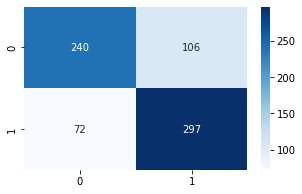

In [81]:
## classification results

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [82]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.7369727047146402
Recall 0.8048780487804879
F1-Score 0.7694300518134715


In [83]:
## tf-idf with nlp classifiers (1/2/3-gram)
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))

Accuracy of log reg: 0.73006993006993
Accuracy of naive bayes: 0.6251748251748251
Accuracy of linear svc: 0.7510489510489511
Accuracy of CART: 0.6111888111888112
Accuracy of random forest: 0.7104895104895105
